In [113]:
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random
import tqdm
from type_tree import TypeTree

In [114]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [115]:
game.play_game(seq)

| X |   | O |
| X | O | X |
|   |   |   |


In [116]:
seq = [10, 5, 4, 0, 2, 3]
print(torch.nn.functional.softmax(model(torch.tensor(seq))[0, -1], dim=0))

tensor([1.1859e-19, 2.4734e-01, 1.0996e-05, 6.4533e-19, 5.7383e-06, 3.1790e-15,
        2.5736e-01, 2.4944e-01, 2.4583e-01, 4.5809e-11], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [117]:
def get_head_attention(seq: torch.Tensor) -> torch.Tensor:
    def hook(module, input, output):
        module.attention = output.clone()

    try:
        handle = model.blocks[0].hook_attn_out.register_forward_hook(hook)
        _ = model(seq)
        attention = model.blocks[0].hook_attn_out.attention
    except Exception as e:
        handle.remove()
        raise e

    return attention

In [118]:
games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
games.head()

/tmp/ipykernel_7788/629368561.py:1: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.



,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [119]:
moves = list(range(1, 9))

In [120]:
tt = TypeTree()

In [121]:
z_seqs = [[0, snd] for snd in moves]
other_seqs = [[[fst, snd] for fst in moves if fst != snd] for snd in moves]

In [122]:
tt(z_seqs)
tt(other_seqs)

list: 8
    |_list: 2
        |__int
list: 8
    |_list: 7
        |_list: 2
            |__int


In [123]:
z_seqs

[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8]]

In [124]:
other_seqs

[[[2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1]],
 [[1, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2], [8, 2]],
 [[1, 3], [2, 3], [4, 3], [5, 3], [6, 3], [7, 3], [8, 3]],
 [[1, 4], [2, 4], [3, 4], [5, 4], [6, 4], [7, 4], [8, 4]],
 [[1, 5], [2, 5], [3, 5], [4, 5], [6, 5], [7, 5], [8, 5]],
 [[1, 6], [2, 6], [3, 6], [4, 6], [5, 6], [7, 6], [8, 6]],
 [[1, 7], [2, 7], [3, 7], [4, 7], [5, 7], [6, 7], [8, 7]],
 [[1, 8], [2, 8], [3, 8], [4, 8], [5, 8], [6, 8], [7, 8]]]

In [125]:
all_acts = []
flatten_acts = []
for i, z_seq in enumerate(z_seqs):
    z_act = get_head_attention((torch.tensor(z_seq)))[0, -1]
    z_acts = []
    for other_seq in other_seqs[i]:
        other_act = get_head_attention((torch.tensor(other_seq)))[0, -1]

        act_diff = other_act - z_act
        z_acts.append(act_diff)
        flatten_acts.append(act_diff)

    all_acts.append(z_acts)

In [126]:
model(torch.tensor([0]))

tensor([[[-112.5757,    6.8837,   14.3793,   11.4950,   12.5446,    7.9569,
            13.1281,   10.7997,   10.2335,    0.5565]]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [127]:
def get_activation_vector(move: int):
    moves = list(range(0, 9))
    moves.remove(move)
    z_seqs = [[10, move, snd] for snd in moves]
    other_seqs = [[[10, fst, snd] for fst in moves if fst != snd] for snd in moves]
    all_acts = []
    flatten_acts = []
    for i, z_seq in enumerate(z_seqs):
        z_act = get_head_attention((torch.tensor(z_seq)))[0, -1]
        z_acts = []
        for other_seq in other_seqs[i]:
            other_act = get_head_attention((torch.tensor(other_seq)))[0, -1]

            act_diff = other_act - z_act
            z_acts.append(act_diff)
            flatten_acts.append(act_diff)

        all_acts.append(z_acts)
    flat_acts = torch.stack(flatten_acts)
    return torch.norm(flat_acts, dim=1)
    # return flat_acts.mean(0)

In [128]:
def get_non_difference_activation_vector(move: int):
    moves = list(range(0, 9))
    other_seqs = [[10, fst] for fst in moves]
    all_acts = []
    for other_seq in other_seqs:
        all_acts.append(get_head_attention((torch.tensor(other_seq)))[0, -1])

    flat_acts = torch.stack(all_acts)
    return torch.norm(flat_acts, dim=1)
    # return flat_acts.mean(0)

In [129]:
magnitudes = get_activation_vector(0)

In [130]:
non_diff_magnitudes = get_non_difference_activation_vector(0)

In [131]:
tt(non_diff_magnitudes)

Tensor (dtype: torch.float32)
    |__dim_0 (9)


In [132]:
all_seqs = torch.stack([torch.tensor([fst, snd]) for fst in moves for snd in moves])

In [133]:
tt(all_seqs)

Tensor (dtype: torch.int64)
    |__dim_0 (64)
    |__dim_1 (2)


In [134]:
model(all_seqs)

tensor([[[  12.9202, -111.7838,   15.6010,  ...,   10.4289,   10.8842,
            10.0236],
         [  11.6933, -113.3922,   13.2765,  ...,   11.0251,   10.0119,
            15.0704]],

        [[  12.9202, -111.7838,   15.6010,  ...,   10.4289,   10.8842,
            10.0236],
         [  16.4115,  -44.3166,  -60.9282,  ...,   14.2754,   14.6771,
             6.1585]],

        [[  12.9202, -111.7838,   15.6010,  ...,   10.4289,   10.8842,
            10.0236],
         [  22.3764,  -39.9297,   22.4219,  ...,   21.1704,   20.7350,
           -47.7491]],

        ...,

        [[  17.8943,   13.2298,   21.4645,  ...,   16.0716,  -79.1071,
           -39.5790],
         [  17.6177,   14.5860,   19.0304,  ...,   15.8841,  -32.9089,
           -18.4987]],

        [[  17.8943,   13.2298,   21.4645,  ...,   16.0716,  -79.1071,
           -39.5790],
         [  16.5660,   13.1528,   17.3598,  ...,  -57.0211,  -35.6308,
           -21.1167]],

        [[  17.8943,   13.2298,   21.4645,  ..

In [135]:
def numpy(t):
    return t.cpu().detach().numpy()

(array([1., 0., 0., 1., 1., 1., 2., 1., 1., 1.]),
 array([6.86128521, 6.95063877, 7.03999233, 7.12934589, 7.21869946,
        7.30805302, 7.39740658, 7.48676014, 7.5761137 , 7.66546726,
        7.75482082]),
 <BarContainer object of 10 artists>)

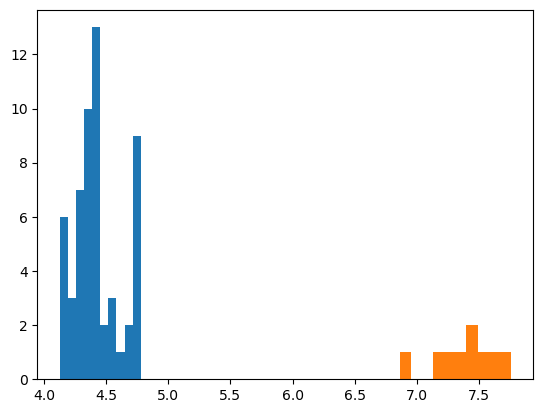

In [136]:
plt.subplot()


plt.hist(numpy(magnitudes))
plt.hist(numpy(non_diff_magnitudes))

In [137]:
def get_activation_vector_second(move: int):
    moves = list(range(0, 9))
    moves.remove(move)
    z_seqs = [[10, snd, move] for snd in moves]
    other_seqs = [[[10, snd, fst] for fst in moves if fst != snd] for snd in moves]
    all_acts = []
    flatten_acts = []
    for i, z_seq in enumerate(z_seqs):
        z_act = get_head_attention((torch.tensor(z_seq)))[0, -1]
        z_acts = []
        for other_seq in other_seqs[i]:
            other_act = get_head_attention((torch.tensor(other_seq)))[0, -1]

            act_diff = z_act - other_act
            z_acts.append(act_diff)
            flatten_acts.append(act_diff)

        all_acts.append(z_acts)
    flat_acts = torch.stack(flatten_acts)
    return flat_acts.mean(0)

In [138]:
zero_act = get_activation_vector(0)
one_act = get_activation_vector(1)
two_act = get_activation_vector(2)
three_act = get_activation_vector(3)
four_act = get_activation_vector(4)
five_act = get_activation_vector(5)
six_act = get_activation_vector(6)
seven_act = get_activation_vector(7)
eight_act = get_activation_vector(8)

In [139]:
zero_act_second = get_activation_vector_second(0)
one_act_second = get_activation_vector_second(1)
two_act_second = get_activation_vector_second(2)
three_act_second = get_activation_vector_second(3)
four_act_second = get_activation_vector_second(4)
five_act_second = get_activation_vector_second(5)
six_act_second = get_activation_vector_second(6)
seven_act_second = get_activation_vector_second(7)
eight_act_second = get_activation_vector_second(8)

In [140]:
mean_acts = torch.stack(
    [
        zero_act,
        one_act,
        two_act,
        three_act,
        four_act,
        five_act,
        six_act,
        seven_act,
        eight_act,
    ]
)
plot.imshow(mean_acts)

In [141]:
mean_acts_second = torch.stack(
    [
        zero_act_second,
        one_act_second,
        two_act_second,
        three_act_second,
        four_act_second,
        five_act_second,
        six_act_second,
        seven_act_second,
        eight_act_second,
    ]
)
plot.imshow(mean_acts_second)

In [142]:
# all_mean_acts = torch.stack(
#     [
#         zero_act,
#         one_act,
#         two_act,
#         three_act,
#         four_act,
#         five_act,
#         six_act,
#         seven_act,
#         eight_act,
#         zero_act_second,
#         one_act_second,
#         two_act_second,
#         three_act_second,
#         four_act_second,
#         five_act_second,
#         six_act_second,
#         seven_act_second,
#         eight_act_second,
#     ]
# )
# norm_mean_acts = all_mean_acts / torch.norm(all_mean_acts, dim=1, keepdim=True)

In [143]:
# plot.imshow(all_mean_acts @ all_mean_acts.T, aspect="equal")

In [144]:
# plot.imshow(norm_mean_acts @ norm_mean_acts.T, aspect="equal")

In [145]:
tt(flatten_acts)

list: 56
    |__Tensor (dtype: torch.float32)
        |__dim_0 (128)


In [146]:
t_flat_acts = torch.stack(flatten_acts)

In [147]:
z_mean = t_flat_acts.mean(0)

In [148]:
tt(t_flat_acts)

Tensor (dtype: torch.float32)
    |__dim_0 (56)
    |__dim_1 (128)


In [149]:
plot.imshow(t_flat_acts)

In [150]:
plot.imshow(t_flat_acts - t_flat_acts.mean(0))

In [151]:
plot.imshow(torch.stack([t_flat_acts.mean(0), torch.zeros(128).to("cuda")]))

[0, 1] - [2, 1]
[0, 1] - [3, 1]
[0, 1] - [4, 1]

[0, 2] - [1, 2]
[0, 2] - [3, 2]
[0, 2] - [4, 2]

do PCA to find best representative vector
Also take mean across components and compre to PCA

In [152]:
PCA = interpretability.pca(t_flat_acts)

/home/thetis/Code/Tic-Tac-Transformer/alphatoe/interpretability.py:215: UserWarning:

Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)



In [153]:
components = PCA["principal components"]
variances = PCA["variances"]
proj_data = PCA["projected data"]

In [154]:
print(PCA["R2"])
print(variances)

tensor([0.1895, 0.1779, 0.1411, 0.1336, 0.1313, 0.1193, 0.1060],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor([3.8239, 3.5901, 2.8479, 2.6957, 2.6488, 2.4084, 2.1387],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [155]:
plot.imshow(components.T)

In [156]:
plot.imshow(PCA["projected data"])

In [157]:
plot.imshow(t_flat_acts - (PCA["projected data"] @ components.T))

In [158]:
plot.imshow(torch.stack([t_flat_acts.mean(0), torch.zeros(128).to("cuda")]))

In [159]:
o_moves = [0, 2, 3, 4, 5, 6, 7, 8]
o_seqs = [[1, snd] for snd in o_moves]
other_seqs = [[[fst, snd] for fst in o_moves if fst != snd] for snd in o_moves]

In [160]:
o_seqs

[[1, 0], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]]

In [161]:
other_seqs

[[[2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0]],
 [[0, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2], [8, 2]],
 [[0, 3], [2, 3], [4, 3], [5, 3], [6, 3], [7, 3], [8, 3]],
 [[0, 4], [2, 4], [3, 4], [5, 4], [6, 4], [7, 4], [8, 4]],
 [[0, 5], [2, 5], [3, 5], [4, 5], [6, 5], [7, 5], [8, 5]],
 [[0, 6], [2, 6], [3, 6], [4, 6], [5, 6], [7, 6], [8, 6]],
 [[0, 7], [2, 7], [3, 7], [4, 7], [5, 7], [6, 7], [8, 7]],
 [[0, 8], [2, 8], [3, 8], [4, 8], [5, 8], [6, 8], [7, 8]]]

In [162]:
all_acts = []
flatten_acts = []
for i, o_seq in enumerate(o_seqs):
    o_act = get_head_attention((torch.tensor(o_seq)))[0, -1]
    o_acts = []
    for other_seq in other_seqs[i]:
        other_act = get_head_attention((torch.tensor(other_seq)))[0, -1]

        act_diff = o_act - other_act
        o_acts.append(act_diff)
        flatten_acts.append(act_diff)

    all_acts.append(o_acts)

In [163]:
t_flat_acts = torch.stack(flatten_acts)

In [164]:
plot.imshow(t_flat_acts)

In [165]:
o_mean = t_flat_acts.mean(0)

In [166]:
o_mean

tensor([ 0.0832,  0.2754, -0.0744, -0.2132,  0.7792, -1.1675, -0.1949, -0.4946,
         0.6380,  0.1074,  0.8377,  0.4196,  0.3561,  0.3704,  0.9039,  0.3685,
        -0.1866, -0.0355, -0.8460, -0.1686, -0.1552,  0.5567, -0.4190,  1.1889,
         0.0205, -0.0251,  0.1253,  0.4361, -0.0776, -0.2929, -0.1166, -0.6294,
        -0.0768, -0.3465,  0.4864,  0.1416, -0.1171,  0.8183,  0.2859, -0.7089,
        -0.3033,  0.5834, -0.4383,  0.0945, -0.9575,  0.1002, -0.6007, -0.5791,
         0.4293, -0.0493, -0.8959, -0.4337,  0.1158,  0.6617,  0.1391,  0.2498,
         0.2940,  0.7520,  0.5440,  0.0746, -0.0853, -0.0386, -0.0090,  0.4834,
         0.1641,  0.0564,  0.3998,  0.0726, -0.2722, -0.0678,  0.0631,  0.0406,
        -0.2997, -0.4171, -0.1114, -0.3590,  0.2296, -0.2025, -0.1868,  0.1212,
         0.2175, -0.1612,  0.0934, -0.1007, -0.1648, -0.5612,  0.2824,  0.0172,
        -0.0776,  0.4429, -0.5861,  0.8569, -0.0229, -0.3542,  0.2687, -0.2658,
        -0.3288, -0.8809,  0.3015, -0.28

In [167]:
def modify_pre_mlp_residuals(seq: torch.Tensor, vec) -> torch.Tensor:
    def hook(module, input, output):
        return output + vec

    try:
        handle = model.blocks[0].hook_attn_out.register_forward_hook(hook)
        out = model(seq)
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return out

In [168]:
seq = [0, 2, 3]
vec = -o_mean + z_mean

In [169]:
print(model(torch.tensor(seq))[0, -1])

tensor([-24.9804,  17.4294, -18.8399, -38.9627,  19.5939,  17.9258,  20.4679,
         18.7262,  19.0319, -29.4440], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [173]:
tt(vec)

Tensor (dtype: torch.float32)
    |__dim_0 (56)


In [171]:
seq = [3, 2, 0]
sub = 0
add = 1
vec = mean_acts[1] - mean_acts[0]

out = model(torch.tensor(seq))
minus_o_out = modify_pre_mlp_residuals(torch.tensor(seq), vec)
plus_o_out = modify_pre_mlp_residuals(torch.tensor(seq), -vec)
print("Normal output", out[0, -1])
print(f"Subtracting {sub}, adding {add}", minus_o_out[0, -1])
print(f"Adding {sub}, subtracting {add}", plus_o_out[0, -1])

RuntimeError: The size of tensor a (128) must match the size of tensor b (56) at non-singleton dimension 2

In [ ]:
seq = [10, 0, 6, 3, 2, 5]
sub = 0
add = 1
vec = (mean_acts_second[add] - mean_acts_second[sub]) * 1

out = model(torch.tensor(seq))
minus_o_out = modify_pre_mlp_residuals(torch.tensor(seq), vec)
plus_o_out = modify_pre_mlp_residuals(torch.tensor(seq), -vec)
print("Normal output", torch.nn.functional.softmax(out[0, -1], dim=0))
print(
    f"Subtracting {sub}, adding {add}",
    torch.nn.functional.softmax(minus_o_out[0, -1], dim=0),
)
print(
    f"Adding {sub}, subtracting {add}",
    torch.nn.functional.softmax(plus_o_out[0, -1], dim=0),
)

Normal output tensor([7.6379e-20, 2.6816e-01, 9.5291e-06, 1.7893e-17, 2.4398e-01, 4.0143e-17,
        4.6815e-06, 2.4215e-01, 2.4569e-01, 1.3911e-13], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Subtracting 0, adding 1 tensor([1.0000e+00, 2.4129e-38, 3.9235e-16, 1.3175e-26, 4.5535e-12, 6.2992e-27,
        2.7215e-16, 9.7623e-12, 7.3315e-12, 1.1538e-23], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Adding 0, subtracting 1 tensor([0.0000e+00, 1.0000e+00, 2.6378e-25, 2.0612e-35, 5.5002e-22, 1.5308e-36,
        3.8403e-27, 1.0623e-22, 5.1277e-23, 0.0000e+00], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


[
    x w1 -> 
    y w2 -> Relu()
    z w3 -> 
]

In [ ]:
seq = [10, 5, 6, 7, 1, 2, 3]
vec = -o_mean + z_mean

out = model(torch.tensor(seq))
minus_o_out = modify_pre_mlp_residuals(torch.tensor(seq), vec)
plus_o_out = modify_pre_mlp_residuals(torch.tensor(seq), 0)
print("Normal output", torch.nn.functional.softmax(out[0, -1], dim=0))
print("Subtracting 0, adding 1", minus_o_out[0, -1])
print("Adding 0, subtracting 1", plus_o_out[0, -1])

Normal output tensor([3.2597e-01, 3.7406e-17, 1.7532e-05, 2.6492e-18, 3.4724e-01, 3.1712e-05,
        2.4671e-18, 3.6727e-05, 3.2671e-01, 5.6541e-13], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Subtracting 0, adding 1 tensor([ 58.4793,  28.2900,  -9.6893, -31.5554,  -1.6543,  -5.7888, -33.1635,
         -9.6578,  -2.2023,   0.5545], device='cuda:0',
       grad_fn=<SelectBackward0>)
Adding 0, subtracting 1 tensor([ 16.6750, -20.0287,   6.8445, -22.6763,  16.7382,   7.4371, -22.7475,
          7.5840,  16.6773, -10.4053], device='cuda:0',
       grad_fn=<SelectBackward0>)


If we want to test how all the activation vectors look even as we increase sequence size

In [172]:
seq = [10]
vec = zero_act + two_act + three_act

out = model(torch.tensor(seq))
minus_o_out = modify_pre_mlp_residuals(torch.tensor(seq), vec)
plus_o_out = modify_pre_mlp_residuals(torch.tensor(seq), 0)
print("Normal output", torch.nn.functional.softmax(out[0, -1], dim=0))
print("Subtracting 0, adding 1", minus_o_out[0, -1])
print("Adding 0, subtracting 1", plus_o_out[0, -1])

RuntimeError: The size of tensor a (128) must match the size of tensor b (56) at non-singleton dimension 2